In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import torch
from functools import partial
from in_progress.regularizers import _compute_jet_old, _jvp
from in_progress.visualize_regularizers import compute_vector_field_grid
from in_progress.test_dynamics import WarpedRingAttractorRNN, RNNToODE, RbfPerturbedRingAttractorODE  # noqa
from torch import Tensor
from typing import Optional, Callable
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
eps = np.finfo(np.float32).eps

In [ ]:
import torch
from torch.func import jvp, vmap, jacfwd

stream_F = lambda F_: compute_vector_field_grid(F_, (-2, 2), n_points=100, device=None)
old = np.mgrid[-2:2:100j, -2:2:100j]
pts = torch.tensor(np.moveaxis(old, 0, -1).reshape(-1, 2), dtype=torch.float32)

from typing import Callable, Any

def n_fold_jvp(
    fun1: Callable[..., Any],
    fun2: Callable[[Any], Any],
    x: Any,
    n: int
) -> Any:
    """
    Compute the n-th directional JVP of fun1(x, fun2) along v = fun2(x),
    using your _jvp that returns only the tangent.

    Args:
      fun1: function of signature fun1(x, fun2) -> y
      fun2: function of signature fun2(x) -> v
      x:     primal input
      n:     order of the JVP (must be >= 1)

    Returns:
      The n-th directional derivative: dim^n/dx^n fun1(x, fun2)[ v, ..., v ].
    """
    if n < 0:
        raise ValueError(f"n must be >= 1, got {n}")
    if n == 0:
        return fun1(x, fun2)
    if n == 1:
        # base case: first JVP
        return _jvp(fun1, (x, fun2), (fun2(x),), argnums=0)
    # recursive step: feed previous-order tangent into a fresh _jvp
    prev_tangent = n_fold_jvp(fun1, fun2, x, n - 1)
    return _jvp(fun1, (x, fun2), (prev_tangent,), argnums=0)

import torch

def batch_eigs_on_complement(
    P_sym: torch.Tensor,    # (*batch, n, n), symmetric
    r1:    torch.Tensor,    # (*batch, n)
    eps:   float = 1e-6
) -> torch.Tensor:
    """
    For each batch‐element i:
      • if ||r1[i]|| < eps, returns torch.linalg.eigvalsh(P_sym[i])  (n values)
      • otherwise, computes the n-1 eigenvalues on {r1[i]}^⊥ and
        appends a 1.0 to make n values in total.

    Returns:
      Tensor of shape (*batch, n).
    """
    # flatten batch dims
    *batch_shape, n, _ = P_sym.shape
    P_flat = P_sym.reshape(-1, n, n)
    r1_flat = r1.reshape(-1, n)

    out = []
    for P_i, r1_i in zip(P_flat, r1_flat):
        norm = r1_i.norm()
        if norm < eps:
            # nearly zero: full-spectrum
            vals = torch.linalg.eigvalsh(P_i)
        else:
            # restrict to orthogonal complement
            v = r1_i / norm
            # SVD to get basis for v⊥:
            # v.unsqueeze(0): shape (1, n)
            _, _, Vh = torch.linalg.svd(v.unsqueeze(0))
            Q = Vh.T[:, 1:]               # (n, n-1)
            P_proj = Q.T @ P_i @ Q        # (n-1, n-1)
            vals_comp = torch.linalg.eigvalsh(P_proj)
            # pad with a 1.0
            pad = torch.ones(1, device=vals_comp.device, dtype=vals_comp.dtype)
            vals = torch.cat([vals_comp, pad], dim=0)
        out.append(vals)

    # stack and restore batch shape
    return torch.stack(out, dim=0).reshape(*batch_shape, n)

def kcc_curvatures(x: torch.Tensor, f: callable) -> torch.Tensor:
    """
    Pointwise KCC curvatures = eigvalsh( P_sym ) with
      P_sym = w @ w^T + diag( H[f,f] ).
    Returns shape (*batch, n).
    """
    r1 = f(x)                                        # (*batch, n)
    Df = lambda p, v1: _jvp(f, (p,), (v1,))  # noqa
    Df2_v = lambda p, v1, v2: _jvp(Df, (p, v1), (v2,))  # noqa
    A = vmap(jacfwd(f))(x)                         # (*batch, n, n)
    Hff = Df2_v(x, r1,r1)  # (*batch, n)

    P_sym = A @ A.transpose(-2, -1)                  # (*batch, n, n)
    idx = torch.arange(Hff.size(-1), device=Hff.device)
    P_sym[..., idx, idx] += Hff.abs()
    """
    Original isn't symmetric and PSD
    P_sym = w @ w
    idx = torch.arange(Hff.size(-1), device=Hff.device)
    P_sym[..., idx, idx] += Hff
    """

    # Real spectrum
    # return torch.linalg.eigvalsh(P_sym)             # (*batch, n)
    return batch_eigs_on_complement(P_sym,r1)

def jet(f:Callable[[Tensor],Tensor],x:Tensor, order:int=1, normalize=True, no_linear=True):
    x = x.flatten(start_dim=0, end_dim=-2) if x.ndim >= 2 else x
    j = torch.vmap(lambda _x:_compute_jet_old(f, _x, 4, normalize=normalize, no_linear=no_linear))(x)
    j = j[..., 0:]
    j =torch.swapdims(j.reshape(100,100,2,-1), 0, 1).numpy()
    return j

njet = lambda j: np.linalg.vector_norm(j.numpy() if isinstance(j, Tensor) else j, axis=-2)

from torch.func import jacfwd, hessian


def pairwise_dep(x: np.ndarray) -> np.ndarray:
    """
    x: array of shape [B1, B2, 2, 4]
    returns: array of shape [4, 4] where entry (p,q)
             is the median cosine similarity between vectors p and q
             across all B1*B2 samples.
    """
    B1, B2, dim, n_vec = x.shape
    B = B1 * B2

    # 1) collapse batch dims → [B, 2, 4]
    M = x.reshape(B, dim, n_vec)

    # 2) dot products for each pair → [B, 4, 4]
    #    M[b,:,p] ⋅ M[b,:,q] = sum over dimension axis=1
    dots = np.einsum('bip,biq->bpq', M, M)

    # 3) norms of each vector → [B, 4]
    norms = np.linalg.norm(M, axis=1)

    # 4) outer product of norms → [B,4,4]
    denom = norms[:, :, None] * norms[:, None, :]

    # 5) cosine‐similarities → [B, 4, 4]
    #    add a tiny eps to avoid division‐by‐zero if needed
    cosines = dots / (denom + 1e-12)

    # 6) median across the batch axis → [4, 4]
    return np.median(cosines, axis=0)

R = lambda J,o1,o2=0:1-(torch.nn.functional.cosine_similarity(torch.tensor(J).flatten(start_dim=0, end_dim=-3)[...,o1],torch.tensor(J).flatten(start_dim=0, end_dim=-3)[...,o2], dim=-1)).abs().reshape(100,100).numpy()

class LDS(torch.nn.Module):
    def __init__(self,A:Optional[Tensor]=None):
        super().__init__()
        if not A:
            A = torch.tensor([[0.0, -1.0], [1.0, 0.0]])
        self.A = A

    def forward(self, x: Tensor) -> Tensor:
        return x @ self.A

def rosenbrock(x: Tensor, alpha: Optional[float] = None) -> Tensor:
    if alpha is None:
        alpha = 0.0
    x_coord = x[..., 0]
    y_coord = x[..., 1]
    grad_x = - alpha * (2 * (1 - x_coord)) - 4 * x_coord * (y_coord - x_coord ** 2)
    grad_y = 2 * (y_coord - x_coord ** 2)
    gradient = torch.stack([grad_x, grad_y], dim=-1)
    return - gradient


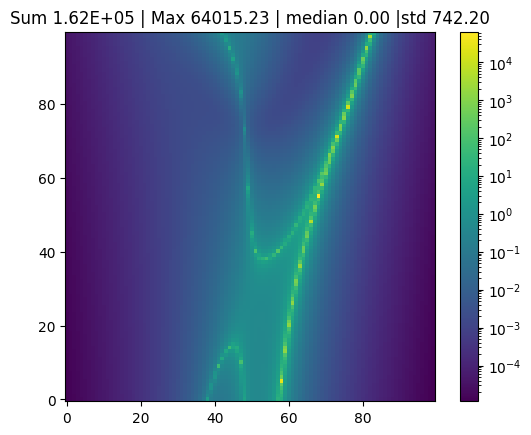

In [543]:
def extrinsic_graph_curvature(x: torch.Tensor, f: callable):
    """
    x: (*batch, n), requires_grad=True
    f: R^n→R^n
    Returns:
      - H_mean: (*batch, )   Euclidean norm of mean curvature vector
      - S_vals: (*batch, n, n) normal-curvature eigenvalues for each normal basis
    """
    *batch, n = x.shape

    # 1) Jacobian J: (*batch, n, n)
    J = vmap(jacfwd(f))(x)
    F = vmap(f)(x)
    # F /= torch.linalg.norm(F, dim=-1, keepdim=True)  # normalize F

    # 2) Build metric g = I + J^T J  and its inverse g_inv
    g = torch.eye(n, device=x.device).expand(*batch, n, n) + J.transpose(-2,-1) @ J
    g_inv = torch.linalg.inv(g)

    # 3) Hessian of each component f^alpha: H_alpha[..., i, j]
    # Stack into (*batch, n, n, n)
    H = torch.vmap(hessian(f))(x)
    # Now H[..., α, i, j] = ∂²f^α/∂x^i∂x^j

    # 4) Mean curvature vector H^α = (1/n) g^ij H^α_{ij}
    U = (g_inv.unsqueeze(-3) * H)  # (*batch, n)
    # H_mean = U.sum(dim=(-1,-2)) / n                          # (*batch,)
    return torch.einsum('bijk,bi,bj,bk-> b', U, F,F,F)
    # return U, F
# F = RbfPerturbedRingAttractorODE(perturbation_magnitude=0.5)
F = partial(rosenbrock,alpha=torch.tensor(2))
# F = LDS()
# a = n_fold_jvp(kcc_curvatures,F, pts, 1).abs().numpy().reshape(100,100,-1)[...,0].T
# a = n_fold_jvp(extrinsic_graph_curvature,F, pts,1)
a = extrinsic_graph_curvature(pts,F)
a = a.reshape(100,100).abs().numpy().T
# a = persistence_regularizer_per_point(F,pts).reshape(100,100).numpy().T
plt.imshow(a, norm=LogNorm(),origin='lower')
plt.title(f'Sum {np.sum(a):.2E} | Max {np.nanmax(a):.2f} | median {np.nanmedian(a):.2f} |std {np.std(a):.2f}')
plt.colorbar()

In [510]:
torch.vmap(torch.dot,in_dims=(0,0))(VN, V)

tensor([-1.4164e-07, -2.6182e-01, -5.0740e-01,  ..., -5.0740e-01,
        -2.6182e-01, -1.4164e-07])

In [467]:
def persistence_regularizer_per_point(
    f: callable,
    x: torch.Tensor,
    eps: float = 1e-6
) -> torch.Tensor:
    """
    For each x in (*batch_dims, n), compute
      R(x) = ||r4||^2 / (alpha - ||II||)^2,

    using:
      - jvp for r1…r4,
      - vmap(jacobian) for w,
      - vmap(hessian)    for H (vector-output Hessian).

    Returns a tensor of shape (*batch_dims,) with no reduction.
    """
    # flatten any batch dims → (B, n)
    *batch_dims, n = x.shape
    x_flat = x.reshape(-1, n)

    # 1) first four prolongations via jvp
    r1 = f(x_flat)
    _, r2 = jvp(f, (x_flat,), (r1,))

    def flow(z):
        _, y = jvp(f, (z,), (f(z),))
        return y

    _, r3 = jvp(flow, (x_flat,), (r1,))
    _, r4 = jvp(flow, (x_flat,), (r3,))
    r4_sq = (r4**2).sum(dim=-1)            # (B,)

    # 2) Jacobian w & α = σ_min(w)
    A = vmap(jacfwd(f))(x_flat)          # (B, n, n)
    M = A @ A.transpose(-2, -1)            # (B, n, n)
    σ2_min = torch.linalg.eigvalsh(M).amin(dim=-1)  # (B,)
    alpha = torch.sqrt(torch.clamp(σ2_min, min=eps))

    # 3) Hessian tensor H[b, α, i, j] via a single batched hessian
    #    hessian(f) maps (n,) → (n,n,n); vmap over batch gives (B,n,n,n)
    H = vmap(hessian(f))(x_flat)           # (B, n, n, n)

    # 4) compute II_sq = g^{-1}_{ik} g^{-1}_{jl} ∑_α H[b,α,i,j] H[b,α,k,l]
    eye = torch.eye(n, device=x.device).unsqueeze(0).expand(x_flat.size(0), n, n)
    g = eye + M                             # (B, n, n)
    g_inv = torch.linalg.inv(g)            # (B, n, n)

    #    einsum over b,i,k; b,j,l; b,α,i,j; b,α,k,l → (B,)
    II_sq = torch.einsum('bik,bjl,bail,bakl->b',
                        g_inv, g_inv, H, H)

    # 5) per-point regularizer R = r4_sq / (α - √II_sq)^2
    denom = alpha - torch.sqrt(II_sq + eps)
    denom = torch.clamp(denom, min=eps)
    R_flat = r4_sq / (denom * denom)       # (B,)

    # reshape back to (*batch_dims,)
    return R_flat.reshape(*batch_dims)

array([[4.5075516e+24, 4.3735796e+07, 9.7086928e+07, ..., 2.5155264e+07,
        5.0927880e+07, 2.3189277e+21],
       [3.3200820e+07, 5.9245604e+07, 1.1430648e+08, ..., 1.3662012e+07,
        2.8845746e+07, 5.1385124e+07],
       [4.5745420e+07, 7.1333336e+07, 1.1454990e+08, ..., 6.7327755e+06,
        1.4742965e+07, 2.8986464e+07],
       ...,
       [2.0932196e+07, 1.7335298e+07, 1.4519590e+07, ..., 1.3155603e+07,
        7.0944630e+06, 2.1065058e+07],
       [2.6062182e+07, 2.1720850e+07, 1.8073892e+07, ..., 6.5981565e+06,
        1.3815065e+07, 7.2202616e+07],
       [1.4527212e+21, 2.7027326e+07, 2.2479102e+07, ..., 1.2626990e+07,
        5.8860708e+07, 2.0747385e+23]], shape=(100, 100), dtype=float32)

In [ ]:
# F = LDS()
F = lambda x: rosenbrock(x, alpha=0.1)
# F = ra
order = 3

J = jet(F, pts, order=4, normalize=True, no_linear=False)
jet_norm = njet(J)[...,order]

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].streamplot(*stream_F(F), linewidth=0.5)
axs[0].set_title("Vector field")

axs[1].streamplot(np.linspace(-2,2,100),np.linspace(-2,2,100),J[...,0,order],J[...,1,order], linewidth=0.5)
axs[1].set_title("Vector field")

im1 = axs[-2].imshow(kcc_curvatures(pts, F).numpy().reshape(100,100,-1)[...,0].T, cmap='viridis', norm=LogNorm(vmin=2 * eps, vmax=np.amax(jet_norm)+3*eps, clip=True),extent=(-2, 2, -2, 2), origin='lower', aspect='auto')
im1 = axs[-1].imshow(kcc_curvatures(pts, F).numpy().reshape(100,100,-1)[...,1].T, cmap='viridis', norm=LogNorm(vmin=2 * eps, vmax=np.amax(jet_norm)+3*eps, clip=True),
    extent=(-2, 2, -2, 2), origin='lower', aspect='auto')
# axs[-2].imshow(R(J,order),origin='lower',aspect='auto')
#
# im1 = axs[-1].imshow(jet_norm, cmap='viridis', norm=LogNorm(vmin=2 * eps, vmax=np.amax(jet_norm)+3*eps, clip=True),
#     extent=(-2, 2, -2, 2), origin='lower', aspect='auto')
fig.colorbar(im1, ax=axs[-1], orientation="vertical", shrink=0.6, aspect=30)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import combinations

F = lambda x: rosenbrock(x, alpha=0.02)
ra = RbfPerturbedRingAttractorODE(perturbation_magnitude=0.001)
# F = ra
J = jet(F, pts, order=4, normalize=True, no_linear=True)


N = J.shape[-1]

# 1. Only unordered pairs o1<o2
pairs = list(combinations(range(N), 2))

# 2. Precompute global vmin/vmax for LogNorm
images = [R(J, o1, o2) for (o1, o2) in pairs]
all_max = np.nanmax([img.max() for img in images]) + eps
all_min = np.abs(np.nanmin([img.min() for img in images])) + eps
common_norm = LogNorm(vmin=all_min, vmax=all_max)

# 3. Create an N×N grid
fig, axs = plt.subplots(N, N, figsize=(3*N, 3*N))

# 4. Plot each pair in its (o1,o2) location
for o1 in range(N):
    for o2 in range(N):
        ax = axs[o1, o2]
        if (o1, o2) in pairs:
            img = R(J, o1, o2)
            ax.imshow(img, origin='lower', aspect='auto', norm=common_norm)
            ax.set_title(f"({o1},{o2})")
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()